# Classification approaches
Many hyperspectral mapping tasks revolve around classification of e.g. lithology or metallurgical domains. Machine learning approaches can be applied to perform supervised and unsupervised classifications , but knowledge-based classifications can also be created using a decision tree. 

In [1]:
import hylite
from hylite import io
import matplotlib.pyplot as plt
import numpy as np
from hylite.analyse import band_ratio

In [2]:
%matplotlib inline

In [3]:
# load datasets to play with
enmap = io.load( '/Users/rachdi18/Documents/Namibia_Epembe/final_subsets/final/enmap_final_sub.hdr' )
Prisma=io.load('/Users/rachdi18/Documents/Namibia_Epembe/final_subsets/final/prisma_final_sub.hdr')
EMIT=io.load('/Users/rachdi18/Documents/Namibia_Epembe/final_subsets/final/emit_final_sub.hdr')
hymap=io.load('/Users/rachdi18/Documents/Namibia_Epembe/final_subsets/final/hymap_final_sub.hdr')

In [42]:
image=EMIT

We will build our classification based on band ratios results

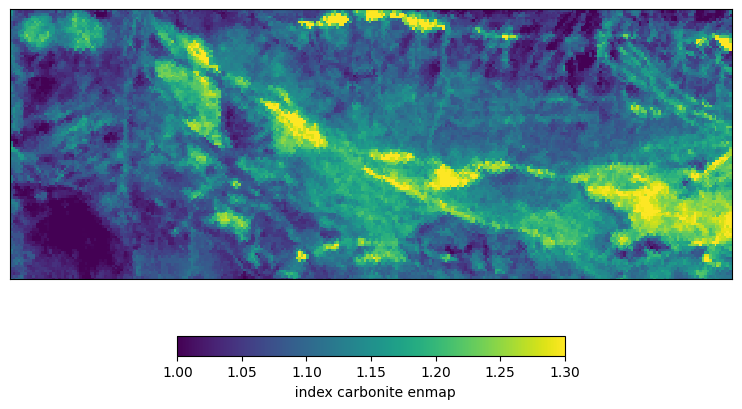

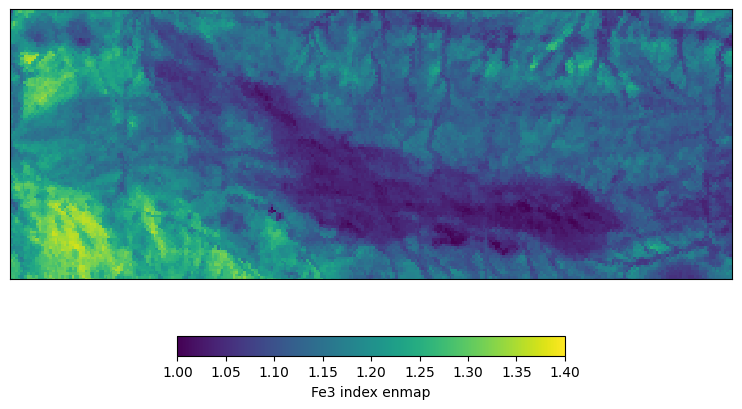

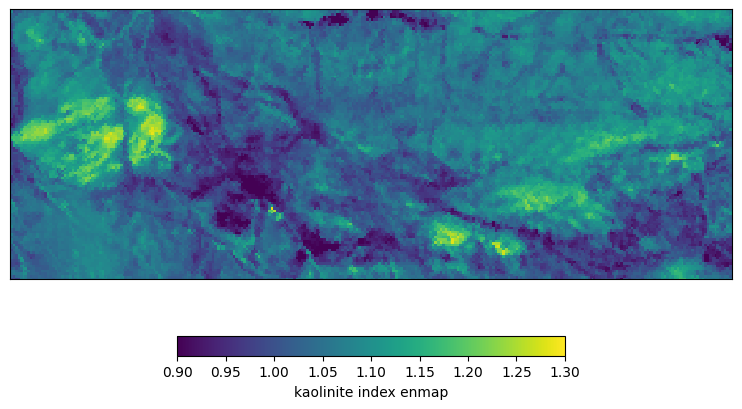

In [44]:
#Band Ratios
# Calcite index
calcite= band_ratio (image, (2190.,2224.),(2293.,2345.))
calcite.data *= band_ratio (image, (2375.6,2430.),(2293.,2345.)).data
calcite.set_as_nan(0)
fig,ax =calcite.quick_plot(vmin=1., vmax=1.3, figsize=(10,5))
cbar = fig.colorbar( ax.cbar, orientation='horizontal', shrink=0.5)
cbar.set_label("  index carbonite enmap")
# Iron index
hematite = band_ratio(image, 600., 570.)
hematite.set_as_nan(0)
fig,ax =hematite.quick_plot(0, vmin=1., vmax=1.4, figsize=(10,5))
cbar = fig.colorbar( ax.cbar, orientation='horizontal', shrink=0.5)
cbar.set_label("Fe3 index enmap")
fig.show()
# Kaolinite index
kaolinite = band_ratio(image,(1600., 1700.),(2145.,2185.))
kaolinite.data *= band_ratio (image, (2295.,2365.),(2185.,2225.)).data
fig,ax =kaolinite.quick_plot(0, vmin=0.9, vmax=1.3, figsize=(10,5))
cbar = fig.colorbar( ax.cbar, orientation='horizontal', shrink=0.5)
cbar.set_label("kaolinite index enmap")
fig.show()

# Decision trees
Decision trees filter points / pixels based on a set of specific layers to determine class labels (which represent the leaves of the tree). 
Note that this is a binary tree (each layer of the tree is based on a binary decision). Highlight has a function to help construct and classify data using such binary trees. The first step is to decide on the thresholds that determine the difference between low and high. We can do this by creating some histograms:

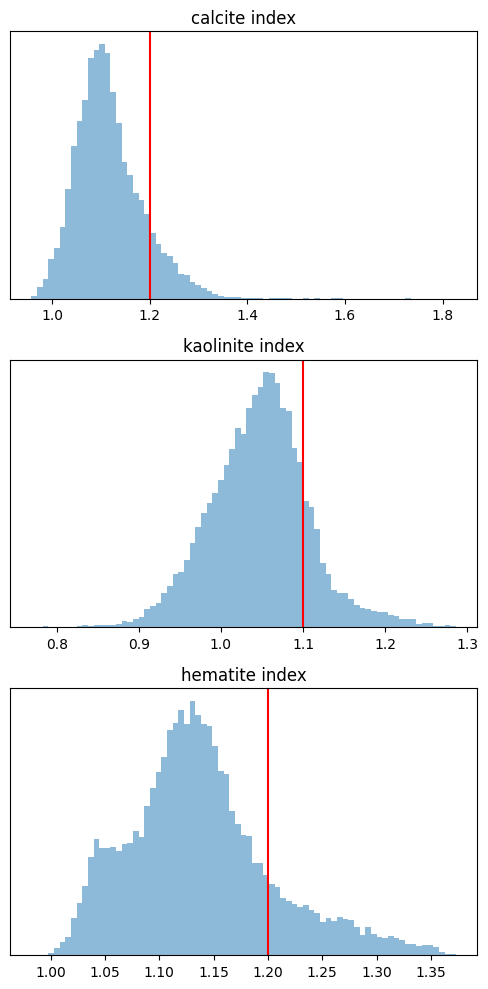

In [45]:
#Threshold
fig,ax = plt.subplots(3,1,figsize=(5,10)) # create matplotlib figure

# define our threshold values
calcite_thresh = 1.2
hematite_thresh = 1.2
kaolinite_thresh = 1.1

# generate calcite histogram
ax[0].hist( calcite.data.ravel(), bins=75, alpha=0.5 ) # plot histogram
ax[0].set_title("calcite index") # add title
ax[0].axvline(calcite_thresh, color='r') # add vertical line showing proposed threshold
ax[0].set_yticks([]) # remove vertical ticks
# generate Fe3 histogram
ax[1].hist( kaolinite.data.ravel(), bins=75, alpha=0.5 )
ax[1].set_title("kaolinite index")
ax[1].axvline(kaolinite_thresh, color='r')
ax[1].set_yticks([])
# generate kaolonite histogram
ax[2].hist( hematite.data.ravel(), bins=75, alpha=0.5 ) # plot histogram
ax[2].set_title("hematite index") # add title
ax[2].axvline(hematite_thresh, color='r') # add vertical line showing proposed threshold
ax[2].set_yticks([]) # remove vertical ticks
fig.tight_layout()
fig.show()

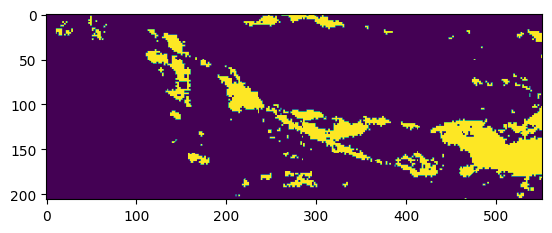

In [46]:
hasCL = calcite.data[..., 0] > calcite_thresh # True if calcite feature is present
hasFe3 = hematite.data[..., 0] > hematite_thresh # True if Fe3 feature is present
hasKL = kaolinite.data[..., 0] > kaolinite_thresh # True if Fe3 feature is present
# plot these boolean layers
plt.imshow( hasCL.T)

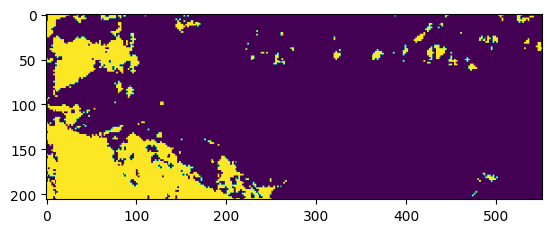

In [47]:
plt.imshow( hasFe3.T)

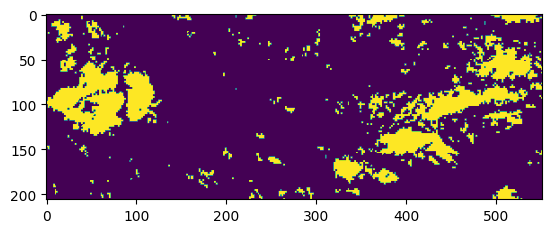

In [48]:
plt.imshow( hasKL.T)

Now we just need to combine these layers to come up with a class label. Hylite has a decision_tree function that can help us do this.

In [49]:
from hylite.analyse import decision_tree

In [50]:
layers = [hasCL, hasKL, hasFe3] # define the layers of our tree
labels = {                        # give leaves of the tree names
          (False,False, True) :  "Mafic",
          (False,True, False) :   "Clays Alteration",
          (True, False, False) : "Carbonatite",
         }

# apply this decision tree to dataset
clf, lab = decision_tree( layers, labels )

clf = hylite.HyImage( clf, bands=clf[...,None] )

Using a few matplotlib tricks we can plot this as a pretty map!

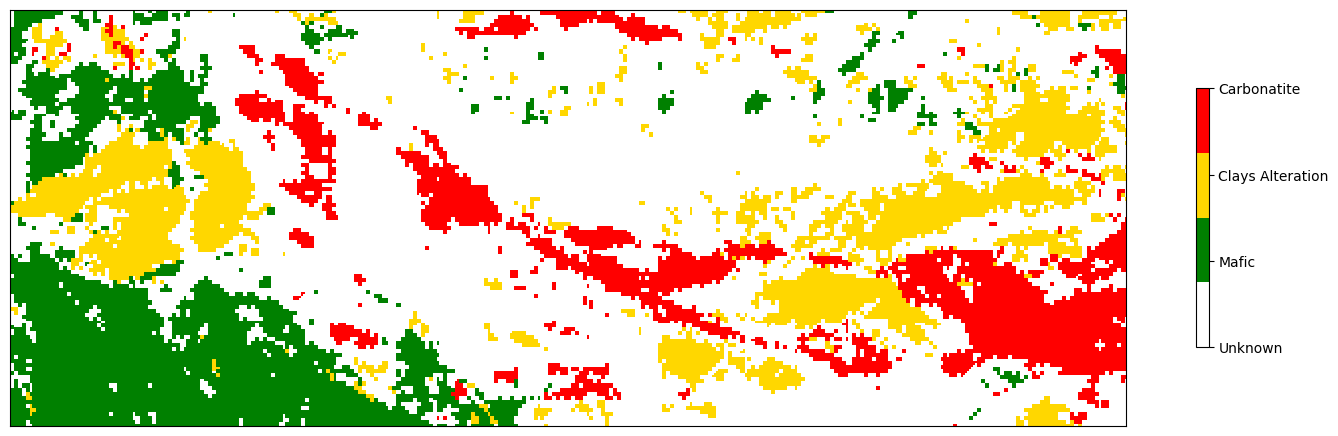

In [51]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['white', 'green', 'gold','red'] )#note that the 'unknown' class is automatically added
fig,ax = clf.quick_plot( 0, cmap=cmap, interpolation = 'none')
cm = fig.colorbar(ax.cbar, shrink=0.5, ticks=range(4))
cm.ax.set_yticklabels(lab)
ax.set_xticks([])
ax.set_yticks([])
fig.show()

In [52]:
# setting the projection and affine transformation for the classifeid image
clf.set_projection_EPSG( image.get_projection_EPSG())
clf.affine = image.affine
io.save('/Users/rachdi18/Documents/Namibia_Epembe/hylite_file/DT/emit', clf)

# SAM CLASSIFICATION


In [14]:
from hylite.analyse import SAM

In [15]:
SAM?

Signature: SAM(data, ref_spec)
Docstring:
Apply a spectral angle classification based on reference spectra.
Args:
    data: the HyData instance (e.g. image or cloud) to apply the classification to.
    ref_spec: a list containing lists of spectra for each class. i.e.:
                ref_spect = [ [class1_spec1, class1_spec2],[class2_spec1, class2_spec2], ... ]
Returns:
    a HyData instance with the same type as data containing two bands: the class index, and the spectral angle to this (closest) class.
File:      ~/anaconda3/lib/python3.10/site-packages/hylite/analyse/sam.py
Type:      function

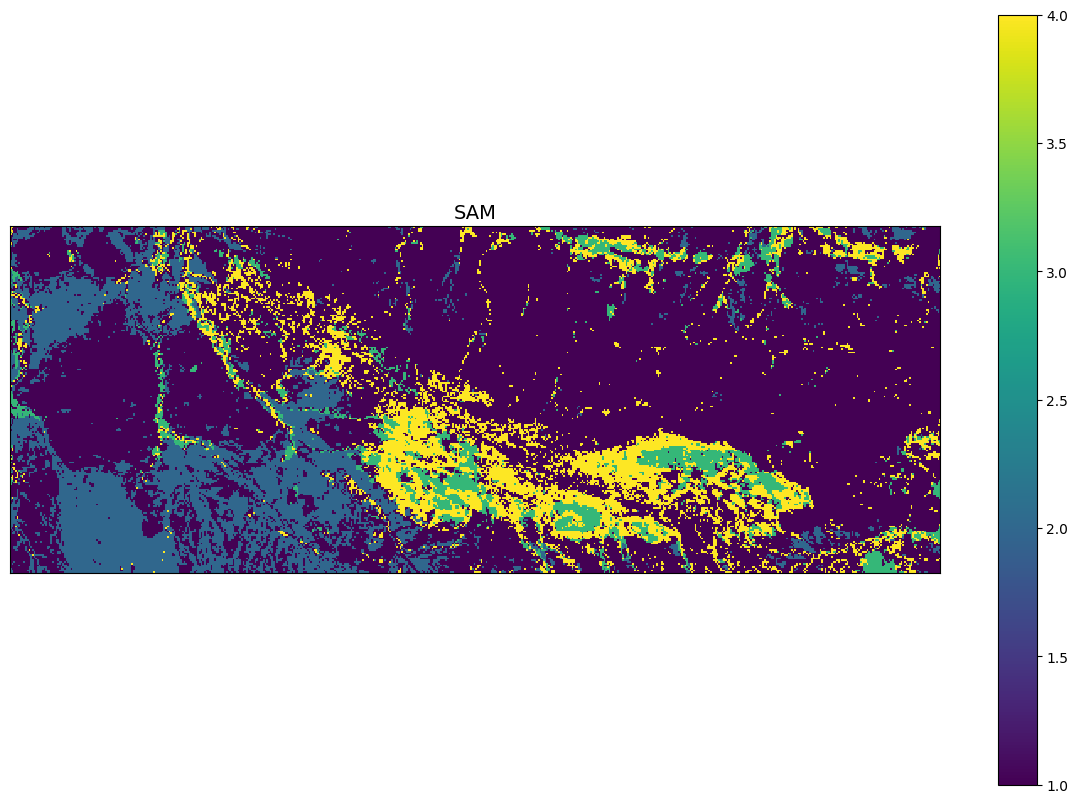

In [16]:
#EnMAP
image=enmap
ref_spect1 = np.array( ( [ [image.data[200,75,:],image.data[236,100,:],image.data[299,136,:],image.data[330,155,:],image.data[170,57,:],image.data[275,125,:]],
                          [image.data[504,130,:],image.data[420,110,:],image.data[310,200,:],image.data[510,155,:],image.data[400,200,:],image.data[460,125,:]],
                          [image.data[77,196,:], image.data[20,60,:], image.data[150,175,:], image.data[40,180,:], image.data[100,144,:], image.data[50,50,:]],
                         [image.data[340,175,:], image.data[338,170,:], image.data[330,168,:], image.data[260,166,:], image.data[270,170,:], image.data[346,170,:]],
                        [image.data[440,158,:], image.data[220,130,:], image.data[260,140,:], image.data[230,135,:], image.data[185,75,:], image.data[230,125,:]],
                         ]) )

from hylite.analyse import SAM
sam1 = SAM( image, ref_spect1 )
sam1.set_projection_EPSG( image.get_projection_EPSG())
sam1.affine = image.affine
fig1,ax1 = sam1.quick_plot(0,vmin=1.,vmax=4.,figsize=(15,10))
fig1.colorbar(ax1.cbar)
ax1.set_title('SAM', fontsize=14)
fig1.show()

In [17]:
io.save('/Users/rachdi18/Documents/Namibia_Epembe/Results/SAM/sam_enmap', sam1)

In [18]:
# converting the data type from uintto floating point
image.decompress()

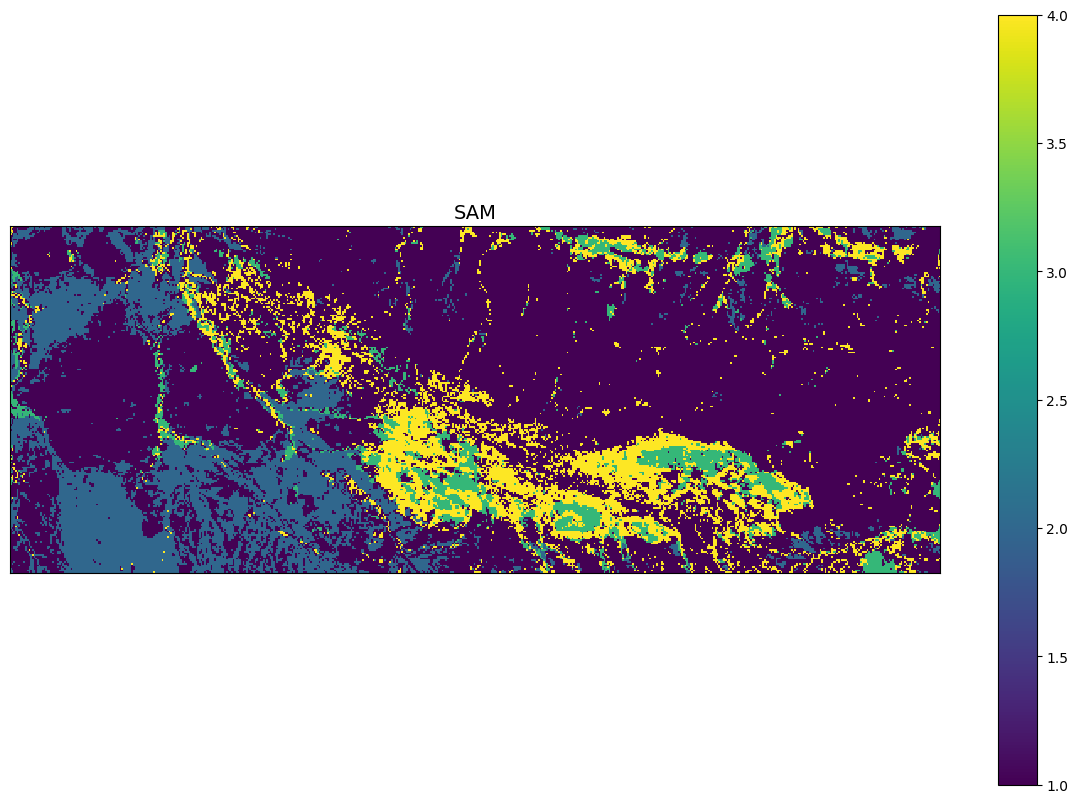

In [19]:
#PRISMA
ref_spect1 = np.array( ( [ [image.data[200,75,:],image.data[236,100,:],image.data[299,136,:],image.data[330,155,:],image.data[170,57,:],image.data[275,125,:]],
                          [image.data[504,130,:],image.data[420,110,:],image.data[310,200,:],image.data[510,155,:],image.data[400,200,:],image.data[460,125,:]],
                          [image.data[77,196,:], image.data[20,60,:], image.data[150,175,:], image.data[40,180,:], image.data[100,144,:], image.data[50,50,:]],
                         [image.data[340,175,:], image.data[338,170,:], image.data[330,168,:], image.data[260,166,:], image.data[270,170,:], image.data[346,170,:]],
                        [image.data[440,158,:], image.data[220,130,:], image.data[260,140,:], image.data[230,135,:], image.data[185,75,:], image.data[230,125,:]],
                         ]) )            
from hylite.analyse import SAM
sam1 = SAM( image, ref_spect1 )
sam1.set_projection_EPSG( image.get_projection_EPSG())
sam1.affine = image.affine
fig1,ax1 = sam1.quick_plot(0,vmin=1.,vmax=4.,figsize=(15,10))
fig1.colorbar(ax1.cbar)
ax1.set_title('SAM', fontsize=14)
fig1.show()